<h1><center>Travelling Salesman Problem (TSP) - Metaheuristcs </center></h1>

<p>Adam Nouwailati</p>
<p>Cristian-Iulian Petre</p>
<p>Tiago Filipe Rosário Costa </p>

[https://github.coventry.ac.uk/380CT-1920JANMAY/TSP-Guidance](https://github.coventry.ac.uk/380CT-1920JANMAY/TSP-Guidance)

# Notation and definitions

Let $G$ be a complete weighted graph with $n$ vertices...

- **Complete**: the graph is undirected, has no self-loops, and each node is connected to all the other vertices.
- **Weighted**: the edges have a weight (a positive integer).
- **Cycle**: a path that visits every vertex once, and goes back to the start point.
- **Total cost of the cycle**: sum of the edge weights of the cycle.

# Definition of the problem

Given $G$ as above, the versions of the TSP are defined as follows:

* **Decisional TSP (D-TSP)**:
> Given a total cost $k$, decide if $G$ is has a cycle of length $\leq k$.

    **NP-complete**, because D-TSP $\in$ NP and D-TSP $\leq_p$ HAMCYCLE.
    
    * D-TSP $\in$ NP: once a cycle is given (a certificate) we can quickly evaluate the its cost in $O(n)$ time to verify it is equal to $k$.
    * D-TSP $\leq_p$ HAMCYCLE: Reduction from HAMCYCLE (Hoos and Stutzler, p.25).

* **Search TSP**:
> Given a total cost $k$, search for a cycle of length $\leq k$ in $G$.
> (If found then return it, otherwise say that there is no such cycle.)
    
* **Optimization TSP**:
> Given $G$, find a cycle of minimal total cost.

    **NP-Hard**, because the optimization version of (decision) NP-complete problems are automatically NP-Hard. (using the same method sketched above for **Search TSP**)

The facts about the complexity classes memberships can also be found in (Garey and Johnson, 1979) and (Hoos and Stutzler, 2005).

# Testing methodology

* **Exact methods**:
    Average time for instances with increasing $n$.

* **Greedy and meta-heuristics**:
    Average "quality" as $n$ increases.


## Random instances sampling strategy

General TSP instances will be generated by creating symmetric adjacency matrices uniformly at random.

# Code

First start by importing relevant libraries.

In [0]:
from random import randint, choice
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import exp, log
from time      import time
import matplotlib.pyplot as plt
import copy

## Basics

Let the set of vertices be $\{0, 1, 2,\ldots, n-1\}$.

Without loss of generality, we can consider $0$ to be the start and end point of cycles.

In [0]:
MAX_DISTANCE = 100

def random_symmetric_graph(n):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    avg_dist = 0
    for i in range(n):
        for j in range(i+1,n):
            v = randint(1,MAX_DISTANCE)
            avg_dist += v
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix, avg_dist/n

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        # a = cycle[i]
        # b = cycle[(i+1)%n]
        c += G[cycle[i]][cycle[i-1]]
    return c

### Example

In [3]:
G, avg_dist = random_symmetric_graph(5)
show(G)

        0   1   2   3   4
    ---------------------
 0 |    ∞  73  31  25  89
 1 |   73   ∞   8  67  90
 2 |   31   8   ∞  51  71
 3 |   25  67  51   ∞   5
 4 |   89  90  71   5   ∞



# Solution methods

## Exact methods -- Exhaustive search

The idea is to:
- Consider vertex $0$ as the start and end point.
- Iterate over all permutations of the vertices $\{1,2,\ldots, n-1\}$.
    -  Calculate cost of each permutation and keep track of minimum cost permutation.
- Return the cycle with minimum cost.

More formally, the pseudo-code is as follows:

**Input**: $G$.

**Output**: a cycle in $G$ of shortest cost.

1. $bestcycle\gets \emptyset$
2. $bestcost\gets \infty$
3. **for all** possible cycles $p$ in $G$ (starting and ending at $0$) **do**
4. $\quad$ $c\gets$ cost of $p$
2. $\quad$ **if** $c<bestcost$ **then**
3. $\qquad$ $bestcycle\gets p$
3. $\qquad$ $bestcost\gets c$
4. $\quad$ **end if**
5. **end for**
6. **return** $bestcycle, bestcost$

There are $(n-1)!$ possible cycles, and each computation of a cycle's cost costs $O(n)$. So this algorithm costs $$O((n-1)!\cdot n)=O(n!).$$

In [0]:
def exhaustive_search(G):
    n = len(G)    
    best_cost = oo # infinity
    best_cycle = []
    for cycle in permutations(range(1,n)): # permutations of [1,2,...,n]
        cycle=[0]+list(cycle)              # add the starting city: 0
        c = cost(G, cycle)
        if c < best_cost:
            best_cost = c
            best_cycle = cycle
    return (best_cycle, best_cost)

## Testing

In [5]:
pnts_n = []
pnts_t = []

n  = 8
t0 = t1 = 0

while t1-t0<1: # in seconds; if it takes too long then stop testing
    G, avg_dist = random_symmetric_graph(n)
    t0 = time()
    exhaustive_search(G)
    t1 = time()
    # record time
    print( f"{n}\t{t1-t0}" )
    pnts_n.append( n )
    pnts_t.append( t1-t0 )
    n += 1

8	0.013941049575805664
9	0.0874631404876709
10	0.6096618175506592
11	6.43343710899353


Let us plot this data to see it visually.

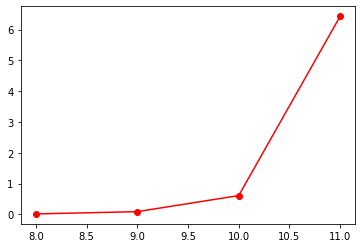

In [6]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

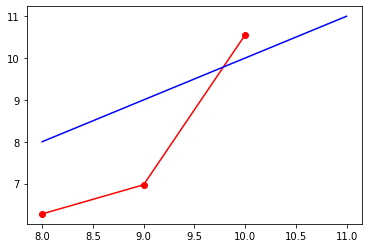

In [7]:
pnts_ratios = [pnts_t[i]/pnts_t[i-1] for i in range(1,len(pnts_n))]
plt.plot(pnts_n[:-1], pnts_ratios, 'ro-')
plt.plot(pnts_n,pnts_n,'b-') # theoretical ratios
plt.show()

### Discussion

* Exhaustive search exhibits combinatorial running time $O(n!)$:
* So it is only useful/possible when $n$ is small, up to about 13 on the current machine if it needs to finish within an hour.

# Approximation

## Greedy search

##### Nearest neigbours

In [0]:
def greedy_nearest_neighbours(G):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cities = list(range(n))
    cycle = [] # solution to be built
    city = 0 # Start city
    while len(cities)>0:
        # Find nearest neighbour
        city_neighbours = H[city]
        smallest_distance = min(city_neighbours)
        nearest_city = city_neighbours.index(smallest_distance)
        # Update 'cycle' and 'cities' and H then 'city'
        cycle.append(city)
        cities.remove(city)
        for i in range(n): # 'city' is not to be used again!
            H[city][i] = oo
            H[i][city] = oo
        city = nearest_city
    return (cycle, cost(G, cycle))


### Example

In [9]:
G, avg_dist = random_symmetric_graph(4)
show(G)
greedy_nearest_neighbours(G)

        0   1   2   3
    -----------------
 0 |    ∞  44  35  78
 1 |   44   ∞  72  90
 2 |   35  72   ∞  80
 3 |   78  90  80   ∞



([0, 2, 1, 3], 275)

### Test

In [10]:
MAX_REPETITIONS = 100

pnts_n = []
pnts_t = []
pnts_q = []

n = 10
t = 0

while t<10: # in seconds; if it takes too long then stop testing
    t = 0
    expected_cycle_length = (MAX_DISTANCE/2)*n # TODO: Better estimate?
    sum_of_avgs = 0

    sum_of_distances = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        t0 = time()
        cycle, c = greedy_nearest_neighbours(G)
        t1 = time()

        sum_of_avgs += (avg_dist/2)*n
        sum_of_distances += c
        t += t1-t0
    # record time and quality
    q = (sum_of_distances/MAX_REPETITIONS)/expected_cycle_length
    q2 = sum_of_distances/sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_q.append( q )
    print( f"{n}\t{t}\t{q}\t{q2}" )
    n *= 2

10	0.023162126541137695	0.52762	0.23024389392425282
20	0.037168025970458984	0.31837	0.067224246928804
40	0.1308600902557373	0.20271	0.020634366027146543
80	0.49896955490112305	0.1231175	0.00616048727982031
160	1.7900347709655762	0.07409	0.0018444000317336879
320	7.196818113327026	0.049616875	0.0006159827811602783
640	29.86957883834839	0.03482125	0.0002158183306339595


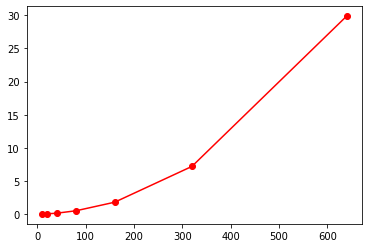

In [11]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

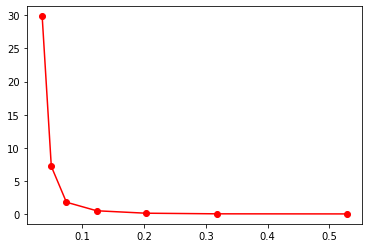

In [12]:
plt.plot(pnts_q, pnts_t, 'ro-')
plt.show()

## Metaheuristics

## 1. Iterative Improvement

### Idea
*   Pre-computed solutions can be passed as input to avoid determining an initial solution.
*   Neighbourhood exploration employs the 2-opt swap technique.
*   The first improved solution is picked on each iteration. Consequently, a subset of each cycle's neighbourhood is ignored in order to speed up the exploration process, but outputs lower quality solutions.


### Pseudocode
**Input**: $G$, $initialCycle$, a function $cost(cycle)$ that returns $cycle$ length

**Output**: local optimum path, length of the path

1. $cycle\gets initialCycle$ **or** $[1, ..., n]$
2. **while** $cycle$ is not a local optimum **do**
3. $\quad$ $improvement\gets$ first neighbour of $cycle$ such that $cost(improvement)<cost(cycle)$
4. $\quad$ $cycle\gets improvement$
5. **end while**
6. **return** $cycle, cost(cycle)$


### Big-O Analysis
Given that
*   The 2-opt swap and cost calculation take $O(n)$ time
*   At worst, finding an improvement will require exploring all the edges, which takes $O(n^{2})$ time
*   There are at most $2^{2n}$ different permutations of all the 2-opt swaps

The worst-case complexity is
 $$O(2^{n}.n^{2}.(n+n)) = O(2^{n}.n^{3})$$



In [0]:
def twoOptSwap(cycle, i, k):
    new_cycle = cycle[:i]
    new_cycle += cycle[i:k+1][::-1]
    new_cycle += cycle[k+1:]
    return new_cycle

def iterative_improvement(G, cycle, best_distance):
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    # cycle, best_distance = greedy_nearest_neighbours(H) # initial sol
    
    improved = True
    while improved:
        improved = False
        # calculate total dist for existing route 
        best_distance = cost(H, cycle)

        for i in range(0, n-2):
            improved = False
        
            for k in range(i+1, n-1):
                # new_cycle = twoOptSwap(cycle, i, k)
                new_cycle = cycle[:i] + cycle[i:k+1][::-1] + cycle[k+1:]
                new_distance = cost(H, new_cycle)
                
                if new_distance < best_distance:
                    cycle = new_cycle
                    best_distance = new_distance
                    improved = True
                    break
            
            if improved:
                break
                    
                
    return (cycle, best_distance)
    

In [14]:
G, _ = random_symmetric_graph(5)
show(G)
cycle, best_distance = greedy_nearest_neighbours(G) # initial sol

iterative_improvement(G, cycle, best_distance)

        0   1   2   3   4
    ---------------------
 0 |    ∞  86  94  38  46
 1 |   86   ∞  93  49  73
 2 |   94  93   ∞  17   1
 3 |   38  49  17   ∞   2
 4 |   46  73   1   2   ∞



([0, 4, 2, 3, 1], 199)

In [15]:
MAX_REPETITIONS = 1

pnts_n = []
pnts_t = []
pnts_q = []

n = 50
t = 0
print( f"sz\titer\tNN\tQ1" )

while t < 15: # in seconds; if it takes too long then stop testing
    t = 0; t2 = 0
    # expected_cycle_length = (MAX_DISTANCE/2)*n # TODO: Better estimate?
    sum_of_distances = 0; sum_of_inits = 0
    sum_of_avgs = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        ti = time()
        cycle, best_distance = greedy_nearest_neighbours(G) # initial sol
        sum_of_inits += best_distance
        t0 = time()
        cycle, c = iterative_improvement(G, cycle, best_distance)
        t1 = time()
        sum_of_distances += c
        sum_of_avgs += (avg_dist/2)*n
        t += t1-t0
        t2 += t0 - ti
    # record time and quality
    q = sum_of_inits / sum_of_avgs
    qi = sum_of_distances / sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_q.append( q )
    print( f"{n}\t{t: .2f}\t{t2: .2f}\t{q: .5f}\t{qi: .5f}" )
    n += 5

sz	iter	NN	Q1
50	 0.04	 0.00	 0.01288	 0.00981
55	 0.09	 0.00	 0.01352	 0.00790
60	 0.14	 0.00	 0.01037	 0.00707
65	 0.11	 0.00	 0.00666	 0.00555
70	 0.12	 0.00	 0.00610	 0.00479
75	 0.13	 0.00	 0.00563	 0.00482
80	 0.20	 0.00	 0.00598	 0.00437
85	 0.26	 0.01	 0.00574	 0.00407
90	 0.37	 0.01	 0.00469	 0.00342
95	 0.62	 0.01	 0.00400	 0.00234
100	 0.26	 0.01	 0.00379	 0.00270
105	 0.28	 0.01	 0.00300	 0.00248
110	 0.68	 0.01	 0.00358	 0.00239
115	 0.61	 0.01	 0.00306	 0.00211
120	 0.46	 0.01	 0.00364	 0.00214
125	 0.73	 0.01	 0.00291	 0.00172
130	 0.72	 0.01	 0.00293	 0.00174
135	 0.98	 0.01	 0.00255	 0.00176
140	 0.81	 0.01	 0.00247	 0.00172
145	 1.44	 0.02	 0.00212	 0.00165
150	 2.10	 0.02	 0.00220	 0.00131
155	 1.24	 0.02	 0.00187	 0.00132
160	 1.74	 0.02	 0.00173	 0.00120
165	 1.66	 0.02	 0.00193	 0.00126
170	 1.83	 0.02	 0.00148	 0.00105
175	 3.33	 0.02	 0.00153	 0.00100
180	 3.07	 0.02	 0.00170	 0.00096
185	 2.58	 0.02	 0.00126	 0.00096
190	 1.70	 0.02	 0.00135	 0.00092
195	 2.87	

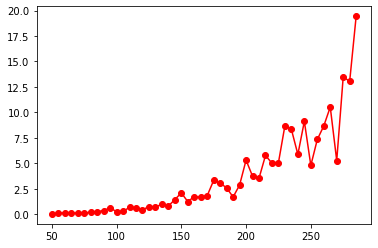

In [16]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.show()

## 2. Simulated Annealing

### Idea

This approach builds on the iterative improvement algorithm by introducing the following mechanics:
*   Each iteration explores a subset of the current candidate's neighbourhood and moves to the best neighbor. Since Simulated Annealing allows for fine-grained configurability, the increased computation time can be mitigated by tuning the configuration parameters.
*   The algorithm starts with the maximum temperature and decreases it logarithmically.
*   A computational budget is allocated for trying to escape local minima. The budget is expended once enough iterations have passed without finding an improved solution candidate. 

### Pseudocode
**Input**: $G$, $maxTemperature$, $coolingFactor$, $K$

**Output**: a cycle in $G$, computed cycle cost

1. Determine initial candidate solution $cycle$
2. $T\gets maxTemperature$
3. **while** global optimum not reached **do**
4. $\quad$ $next \gets$ best neighbour of $cycle$ in $K$ optimisations
5. $\quad$ **if** $cost(next) < cost(cycle)$  **then**
6. $\qquad$ $cycle \gets next$
7. $\quad$ **end if**
8. $\quad$ $T \gets T$ * $coolingFactor$
9. **end while**

10. **return** $cycle, cost(cycle)$

### Big-O Analysis
Given the follwing configuration parameters:
*   $k$ - criterion for the temperature lowering stage, represented as a computational budget 
*   $t$ - initial temperature

A single Simulated Annealing iteration has polynomial time complexity:
 $$O(n.k.t)$$


In [0]:
# SA constants, used for tuning the algo

start_temperature = 1e2
stop_temperature = 5.
MAX_CYCLES = 10
UNCHANGED_FOR_MAX = 50

# temperature scheduling
temp_dropoff = exp(log(stop_temperature / start_temperature) / (MAX_CYCLES-1))

In [0]:
def generate_cycle(G):
    N = len(G)
    taken = [False] * N
    cycle = [0] * N

    for i in range(N-1):
        candidate_idx = randint(0, N-1)
        while taken[candidate_idx]:
            candidate_idx = randint(0, N-1)
        
        cycle[i] = candidate_idx
        taken[candidate_idx] = True

        if i == N-2:
            candidate_idx = 0
            while taken[candidate_idx]:
                candidate_idx += 1

            cycle[i+1] = candidate_idx

    return (cycle, cost(G, cycle))

In [0]:
def randomize(cycle, temperature):
    n = len(cycle) - 1
    for _ in range(int(temperature)):
        idx1 = randint(0, n)
        nxt1 = (idx1+1) % (n+1)
        idx2 = randint(0, n)
        nxt2 = (idx2+1) % (n+1)

        distance = G[cycle[idx1]][cycle[nxt1]] \
                 + G[cycle[idx2]][cycle[nxt2]] \
                 - G[cycle[idx1]][cycle[idx2]] \
                 - G[cycle[nxt1]][cycle[nxt2]]
        if distance > 0:
            # sort indices in ascending order
            if idx2 < idx1:
                idx1, idx2 = idx2, idx1
                nxt1, nxt2 = nxt2, nxt1
            cycle = cycle[:nxt1] + cycle[nxt1:idx2][::-1] + cycle[idx2:]

    return cycle

In [0]:
def sa_iteration(G, cycle, best_distance):
    # set initial temp
    temperature = start_temperature

    crt_cycle = copy.deepcopy(cycle)
    for _ in range(MAX_CYCLES):
        new_cycle = randomize(crt_cycle, temperature)
        new_distance = cost(G, new_cycle)
        
        if new_distance < best_distance:
            cycle = new_cycle
            best_distance = new_distance

        temperature *= temp_dropoff

    return (cycle, best_distance)

In [0]:
def simulated_annealing(G, cycle = None, best_distance = None):
    cycle = cycle or list(range(len(G)))
    best_distance = best_distance or cost(G, cycle)

    distance = best_distance - 1

    # iterate until a local minimum is found
    unchanged_for = 0
    while unchanged_for < UNCHANGED_FOR_MAX:
        if best_distance == distance:
            unchanged_for += 1
        else:
            distance = best_distance
            unchanged_for = 0
            cycle, best_distance = sa_iteration(G, cycle, distance)
    
    return (cycle, best_distance)

In [22]:
G, _ = random_symmetric_graph(5)
show(G)
cycle, best_distance = greedy_nearest_neighbours(G) # initial sol

simulated_annealing(G)

        0   1   2   3   4
    ---------------------
 0 |    ∞  73  16 100  16
 1 |   73   ∞  28  50  99
 2 |   16  28   ∞  22  84
 3 |  100  50  22   ∞  99
 4 |   16  99  84  99   ∞



([0, 1, 2, 3, 4], 238)

# Conclusion

In [23]:
MAX_REPETITIONS = 100

pnts_n = []
pnts_t = []; pnts_t_sa = []
pnts_q = []; pnts_q_sa = []

n = 50
t = 0
print( f"sz\titer\tNN\tQ1" )

while t < 10: # in seconds; if it takes too long then stop testing
    t = t_iter = t_sa = 0
    sum_of_distances = sum_of_inits = sum_of_sa = 0
    sum_of_avgs = 0
    for repetitions in range(MAX_REPETITIONS):
        G, avg_dist = random_symmetric_graph(n)
        ti = time()
        cycle, best_distance = greedy_nearest_neighbours(G) # initial sol
        sum_of_inits += best_distance
        t0 = time()
        # _, c = iterative_improvement(G, cycle, best_distance)
        t1 = time()
        _, sa = simulated_annealing(G)
        t2 = time()
        sum_of_distances += c
        sum_of_sa += sa
        sum_of_avgs += (avg_dist/2)*n
        t_sa += t2 - t1
        # t_iter += t1-t0
        t += t0 - ti
    # record time and quality
    q = sum_of_inits / sum_of_avgs
    # qi = sum_of_distances / sum_of_avgs
    q_sa = sum_of_sa / sum_of_avgs
    pnts_n.append( n )
    pnts_t.append( t )
    pnts_t_sa.append( t_sa )
    pnts_q.append( q )
    pnts_q_sa.append( q_sa )
    # print( f"{n}\t{t: .2f}\t{t_iter: .2f}\t{t_sa: .2f}\t{q: .5f}\t{qi: .5f}\t{q_sa: .5f}" )
    print( f"{n}\t{t: .2f}\t{t_sa: .2f}\t{q: .5f}\t{q_sa: .5f}" )
    n += 50

sz	iter	NN	Q1
50	 0.20	 0.88	 0.01368	 0.04901
100	 0.70	 1.40	 0.00419	 0.02541
150	 1.57	 1.95	 0.00212	 0.01763
200	 2.82	 2.57	 0.00131	 0.01334
250	 4.34	 3.17	 0.00091	 0.01082
300	 6.28	 4.18	 0.00068	 0.00912
350	 8.57	 5.00	 0.00053	 0.00784
400	 11.35	 5.69	 0.00043	 0.00697


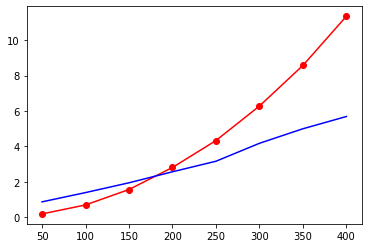

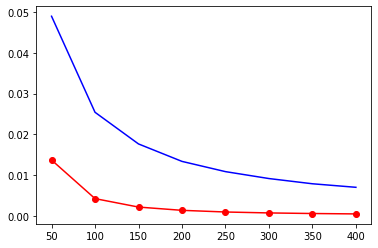

In [24]:
plt.plot(pnts_n, pnts_t, 'ro-')
plt.plot(pnts_n, pnts_t_sa, 'b-')
plt.show()
plt.plot(pnts_n, pnts_q, 'ro-')
plt.plot(pnts_n, pnts_q_sa, 'b-')
plt.show()

**Clear, brief and precise practical recommendations on
which algorithms to use when, based on your computational experiments.**

In [27]:
URL = "https://raw.githubusercontent.com/driimus/380ct/master/eil101.xml?token=AJZHHXZHAZXDJXF2OOF6X4C6TCIOQ"

from google.colab import files
uploaded = files.upload()

Saving ch130.xml to ch130.xml
Saving eil76.xml to eil76.xml
Saving eil101.xml to eil101.xml
Saving kroA150.xml to kroA150.xml
Saving pr299.xml to pr299.xml
Saving rd100.xml to rd100.xml
Saving rd400.xml to rd400.xml
Saving u159.xml to u159.xml


**Testing the Metaheurists**

To test the metaheurists the group decided to search for a library with known solutions for the Travel Salesman Problem. The TSPLIB (TSPLIB/Ruprecht-Karls-Universität Heidelberg) library was choosen for this purporse, this library possesses multiple resources from multiple sources as well as different types.

For our tests we opted to use only Symetric sets, this means that the distance from node i to node j is the same as from node j to node i.

In order to guarantee a big enough range of tests, we choose 8 datasets, that go from 76 elements to 400, (400 beeing the limit due to memory restricitons of the machine). All the tests can be repeated since the datasets are all available to download and execute to confirm the findings both on the website and our github repository.

In [0]:
import pandas as pd 
import xml.etree.ElementTree as et 

def fileParser(file):
  xtree = et.parse(file)
  xroot = xtree.getroot()
  graph=[]
  i=0
  for vertex in xroot.find('graph'):
    temp=[]
    for edge in vertex:
      temp.append(float(edge.get('cost')))
    temp.insert(i, oo)
    i += 1
    graph.append(temp)
  
  return graph

names=["GNN", "II", "SA"]

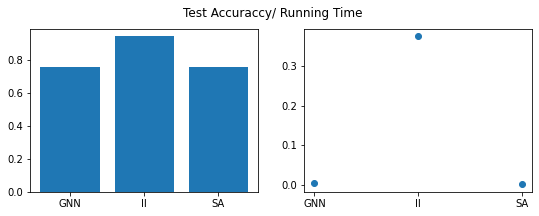

In [32]:
graph76 = fileParser("eil76.xml")

# #Graph76
Opt_Sol = 538
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph76)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph76, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph76, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

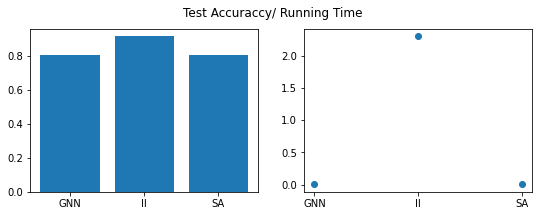

In [33]:
graph130 = fileParser("ch130.xml")

# #Graph130
Opt_Sol = 6110
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph130)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph130, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph130, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

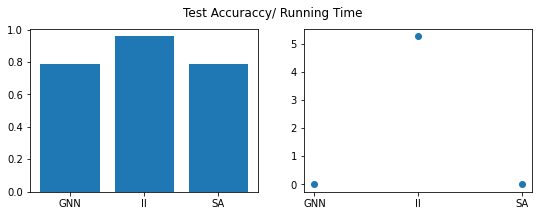

In [34]:
graph150 = fileParser("kroA150.xml")

# #Graph150
Opt_Sol = 26524
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph150)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph150, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph150, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

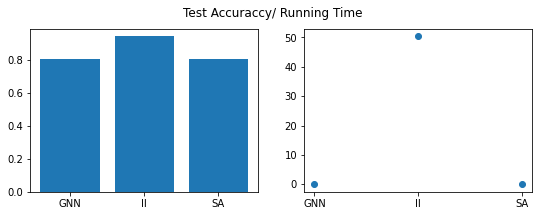

In [35]:
graph299= fileParser("pr299.xml")

# #Graph299
Opt_Sol = 48191
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph299)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph299, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph299, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

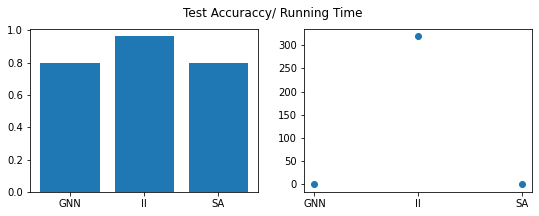

In [36]:
graph400 = fileParser("rd400.xml")

# #Graph400
Opt_Sol = 15281
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph400)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph400, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph400, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

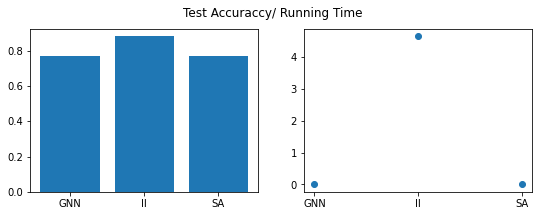

In [37]:
graph159 = fileParser("u159.xml")

# #Graph159
Opt_Sol = 42080
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph159)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph159, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph159, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

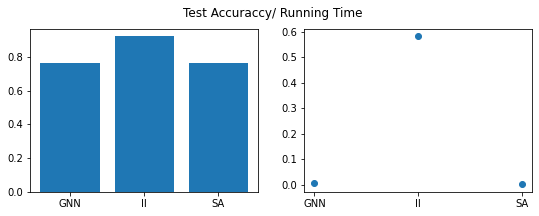

In [38]:
graph101 = fileParser("eil101.xml")

# #Graph101
Opt_Sol = 629
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph101)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph101, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph101, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()

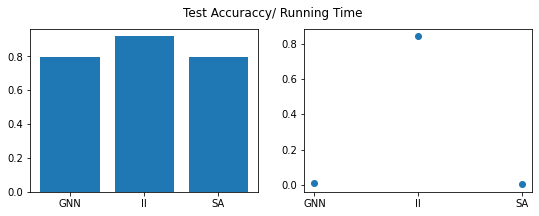

In [39]:
graph100 = fileParser("rd100.xml")

# #Graph100
Opt_Sol = 7910
t0 = time()
cycle, best_distance = greedy_nearest_neighbours(graph100)
t1 = time()
gnntime = t1-t0
GNN=best_distance
t0= time()
_, IIdistance = iterative_improvement(graph100, cycle, best_distance)
t1= time()
iitime = t1-t0
t0=time()
_, SAdistance = simulated_annealing(graph100, cycle, best_distance)
t1=time()
satime=t1-t0

values=[Opt_Sol/GNN, Opt_Sol/IIdistance, Opt_Sol/SAdistance]
valuesTime=[gnntime, iitime, satime]

fig, ax= plt.subplots(1, 2, figsize=(9,3), sharey=False)
ax[0].bar(names, values)
ax[1].scatter(names, valuesTime)
fig.suptitle('Test Accuraccy/ Running Time')

fig.show()


**Recommendation**

There are mutiple approaches to the Travel Salesman Problem, for our coursework we choose to implement Iterative Improvement and Simulated Annealing.

From the analyse of the graphs we can reach two conclusions, first Simulated Annealing method is faster overall in runtime execution that Iterative Improvement, while Iterative Improvement is more accurate when reaching a solution. This comes as result of trading speed for accuracy when on the implementations, and it can be confirmed by checking the big O complexity of the Metaheuristics to confirm this relation.

The results above can be improved for the Simulated Annealing metaheurist, if one tunes the temperature paramenters for each dataset in order to guarantee the best possible results. For this set of tests, we choose not to tune it as to keep tests as similar as possible and so evaluate more accuratly their results.

Based on our experiments we can recommend the usage of Iterative Improvement when searching for a more accurate result that is closer to the optimal value if one does not have any time constrains. 
If a time constrain does exist Simulated Annealing would be the optimal algorithm as it is faster, and it can be tuned to provide more accurate results although the accuracy would still be lower that Iterative Improvement.


# References

* Garey, S. and Johnson, D. (1979)
**Computers and Intractability: A Guide to the Theory of NP-Completeness.**
Freeman.

* Hoos, H. and Stutzler, T. (2005)
**Stochastic Local Search: Foundations and Applications.**
Morgan Kaufmann.

* Sipser, M. (2013).
**Introduction to the theory of computation**
(3rd international ed.). Cengage Learning.
* TSPLIB/Ruprecht-Karls-Universität Heidelberg(n.d) available from <http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/index.html> [01/04/2020]